In [29]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import math

In [30]:
class OutputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "wb")
        return self
       
    def write(self, value, length):
        assert isinstance(value, int), "value must be integer"
        assert isinstance(length, int), "length must be integer"
        assert value >= 0, "value must be non negative"
        assert value < 2 ** length, "value must be smaller than 2 ** length"
       
        self.word <<= length
        self.word |= value
        self.word_bits += length
   
        if self.word_bits >= 64:
            remaining = self.word_bits - 64
            self.file.write((self.word >> remaining).to_bytes(8, byteorder="big", signed=False))
            self.word &= (1 << remaining) - 1
            self.word_bits = remaining
   
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.word_bits != 0:
            self.write(0, 64 - self.word_bits)
           
        self.file.close()

In [4]:
class InputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "rb")
        return self
       
    def read(self, length):
        assert length < 8 * 32, "length is too large"
       
        if length > self.word_bits:
            value = self.file.read(32)
            self.word <<= len(value) * 8
            self.word_bits += len(value) * 8
            self.word |= int.from_bytes(value, byteorder="big", signed=False)
           
        if length > self.word_bits:
            raise "Unexpected end of file"
               
        result = self.word >> (self.word_bits - length)
        self.word_bits -= length
        self.word &= (1 << self.word_bits) - 1
       
        return result
   
    def __exit__(self, exc_type, exc_val, exc_tb):    
        self.file.close()

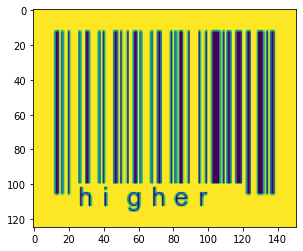

In [31]:
img = imageio.imread("barcodes/sample-000002.png")
plt.imshow(img) #im

primeraLinea = 0
segonaLinea = 0
ultimaRepetida = 0
margeInferior = 0

for fila in range(img.shape[0]):
    for columna in range(img.shape[1]):
        if img[fila][columna] != 255:
            if primeraLinea == 0:
                primeraLinea = fila
                segonaLinea = fila+1


segonaLinea = img[segonaLinea]

for x in range(primeraLinea+1, img.shape[0]):
    
    if False in (img[x] == segonaLinea):
        if ultimaRepetida == 0:
            ultimaRepetida = x


for i in range(img.shape[0]):
    if img[i][12] != 255:
        margeInferior = i


            
#Left Margin
leftMargin = 0
           
for i in range(len(img[ultimaRepetida])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if leftMargin ==0:
            leftMargin = i

            
            
#Right Margin
rightMargin = 0
anterior = 0

#for i in reversed(range(len(img[ultimaRepetida]))):
for i in reversed(range(img.shape[1])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if rightMargin ==0:
            rightMargin = anterior
    anterior = i
            
            
#print(margeInferior)
#print(leftMargin)
#print(rightMargin)
#print('---------')
#print(primeraLinea)
#print(segonaLinea)
#print("La fila es repeteix fins la fila", ultimaRepetida)


In [6]:
#Fins ara tenim una funcio que retorna la ultima fila que es repeteix dins del barcode
# codeBook = primeraLinia + SegonaLinia + totes les linies que no es repeteixen
# a cada linia li podem dir codeword
# per ara hardcodegem les mesures, ja les enviarem

#codeBook =[]
#codeBook.append(img[primeraLinea])
#codeBook.append(segonaLinea)

#wordImage = []

#for i in range(ultimaRepetida, img.shape[0]):
#    for value in img[i]:   
#        wordImage.append(value)
#    codeBook.append(img[i])
#wordImageNP = np.array(wordImage)
#wordImageNP.resize(img.shape[1],img.shape[0]-ultimaRepetida)

#print("Generat Codebook")


In [7]:
def getMSE(img1, img2):  # MSE of 2 images
    return (np.sum(np.square(img1 - img2))) / img1.size


In [33]:
#Obtenir la primera a partir de la segona --> mitja del valor i color blanc(255)

def getFirstLine(common):
    computedPrimera = []

    for el in common:
        newVal = (el+255)//2
        if newVal> (el+(255//2)+0.5):
            newVal+=1
        computedPrimera.append(newVal)
    
    return computedPrimera




In [34]:
shape_x = img.shape[1]
shape_y = img.shape[0]

test1 = np.asarray(img[13]) #common row
test1 = test1.tolist()


#remove first and last 12 255
test = test1[12:-12]

#print(test)


#write
with open('test222.bin', "wb+") as f:
    
    #header
    f.write(shape_y.to_bytes(3, byteorder="big", signed=False))
    f.write(shape_x.to_bytes(3, byteorder="big", signed=False))
    
    
    for i in range(len(test)):
        f.write(test[i].to_bytes(3, byteorder="big", signed=False))
    
    for i in range(12, leftMargin):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    for i in range(rightMargin, shape_x):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
            
            
#read 
commonLine =[]

with open('test222.bin', "rb") as f:
    testReconstructed = []
    read = f.read()
    i=0
    cont=0
    ultimaRepetida = 100
    
    #header
    reconstructed_y = int.from_bytes(read[:3], byteorder="big")
    reconstructed_x = int.from_bytes(read[3:6], byteorder="big")
    
    
    ultimaLinea = [255 for i in range(reconstructed_x)]
    
        
    read = read[6:]
    
    
    for j in range(len(test)):
    
        commonLine.append(int.from_bytes(read[i:i+3], byteorder="big"))
        i+=3
    
    
    #ultima linea
    for j in range(12, leftMargin):
        ultimaLinea[j] = int.from_bytes(read[i:i+3], byteorder="big")
        i+=3
        
    
    for j in range(rightMargin, shape_x):
        ultimaLinea[j] = int.from_bytes(read[i:i+3], byteorder="big")
        i+=3


#reconstruir

#12 first 255
finalReconstructed = [255 for x in range(12)]

#12 last 255
for i in range(12):
    commonLine.append(255)

    
finalReconstructed += commonLine


#print(finalReconstructed)

primera = getFirstLine(finalReconstructed)
ultima = getLastLine(finalReconstructed)


img_reconstructed = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

#asignem la primera fila
img_reconstructed[12] = primera
img_reconstructed[13:ultimaRepetida] = finalReconstructed



#laterals:

#LEFT
for i in range(ultimaRepetida, margeInferior):
    for j in range(leftMargin):
        img_reconstructed[i][j] = finalReconstructed[j]

#RIGHT
for i in range(ultimaRepetida, margeInferior):
    for j in reversed(range(rightMargin, reconstructed_x)):
        img_reconstructed[i][j] = finalReconstructed[j]

        
#Last Line
for j in range(12, leftMargin):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]

for j in reversed(range(rightMargin, reconstructed_x-12)):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]



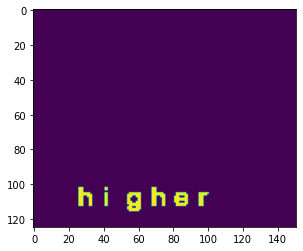

In [35]:
right = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

for i in range(shape_y):
    for j in range(shape_x):
        if img[i][j] == img_reconstructed[i][j]:
            right[i][j] = 0
        
            
        
plt.imshow(np.asarray(right))        

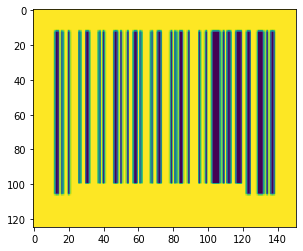

In [11]:
plt.imshow(np.asarray(img_reconstructed))

In [12]:
def rel_freq(x):
    freqs = [(value, x.count(value) / len(x)) for value in set(x)] 
    return sorted(freqs,key=lambda x:x[::-1],reverse=True)

In [13]:
print(shape_y)

125


In [38]:
print((531*8)/(shape_x*shape_y)) #calcul dels bps actuals

0.22505960264900662


In [19]:
#Codi Huffman Encoding
from collections import Counter
from itertools import chain

def count_symbols(pixels):
    values = chain.from_iterable(pixels)
    counts = Counter(values).items()
    return sorted(counts, key=lambda x:x[::-1])

def build_tree(counts) :
    nodes = [entry[::-1] for entry in counts] # Reverse each (symbol,count) tuple
    while len(nodes) > 1 :
        leastTwo = tuple(nodes[0:2]) # get the 2 to combine
        theRest = nodes[2:] # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]  # the branch points freq
        nodes = theRest + [(combFreq, leastTwo)] # add branch point to the end
        print(nodes)
        #nodes.sort() # sort it into place
        sorted(nodes, key=lambda x:x[0])
    return nodes[0] # Return the single tree inside the list
def trim_tree(tree) :
    p = tree[1] # Ignore freq count in [0]
    if type(p) is tuple: # Node, trim left then right and recombine
        return (trim_tree(p[0]), trim_tree(p[1]))
    return p # Leaf, just return it
def assign_codes_impl(codes, node, pat):
    if type(node) == tuple:
        assign_codes_impl(codes, node[0], pat + [0]) # Branch point. Do the left branch
        assign_codes_impl(codes, node[1], pat + [1]) # then do the right branch.
    else:
        codes[node] = pat # A leaf. set its code

def assign_codes(tree):
    codes = {}
    assign_codes_impl(codes, tree, [])
    return codes
def to_binary_list(n):
    """Convert integer into a list of bits"""
    return [n] if (n <= 1) else to_binary_list(n >> 1) + [n & 1]

def from_binary_list(bits):
    """Convert list of bits into an integer"""
    result = 0
    for bit in bits:
        result = (result << 1) | bit
    return result

def pad_bits(bits, n):
    """Prefix list of bits with enough zeros to reach n digits"""
    assert(n >= len(bits))
    return ([0] * (n - len(bits)) + bits)
from PIL import Image

def compressed_size(counts, codes):
    header_size = 2 * 16 # height and width as 16 bit values

    tree_size = len(counts) * (1 + 8) # Leafs: 1 bit flag, 8 bit symbol each
    tree_size += len(counts) - 1 # Nodes: 1 bit flag each
    if tree_size % 8 > 0: # Padding to next full byte
        tree_size += 8 - (tree_size % 8)

    # Sum for each symbol of count * code length
    pixels_size = sum([count * len(codes[symbol]) for symbol, count in counts])
    if pixels_size % 8 > 0: # Padding to next full byte
        pixels_size += 8 - (pixels_size % 8)

    return (header_size + tree_size + pixels_size) / 8

def encode_header(image, bitstream):
    """
    height_bits = pad_bits(to_binary_list(image.height), 16)
    bitstream.write_bits(height_bits)    
    width_bits = pad_bits(to_binary_list(image.width), 16)
    bitstream.write_bits(width_bits)
    """
    height_bits = pad_bits(to_binary_list(image.shape[0]), 16)
    bitstream.write_bits(height_bits)    
    width_bits = pad_bits(to_binary_list(image.shape[1]), 16)
    bitstream.write_bits(width_bits)
    

def encode_tree(tree, bitstream):
    if type(tree) == tuple: # Note - write 0 and encode children
        bitstream.write_bit(0)
        encode_tree(tree[0], bitstream)
        encode_tree(tree[1], bitstream)
    else: # Leaf - write 1, followed by 8 bit symbol
        bitstream.write_bit(1)
        symbol_bits = pad_bits(to_binary_list(tree), 8)
        bitstream.write_bits(symbol_bits)

def encode_pixels(image, codes, bitstream):
    for pixel in image:
        for value in pixel:
            bitstream.write_bits(codes[value])

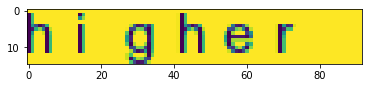

In [29]:
#Encoding process
#to start I need a np.array of the word to encode
wordBefore = np.array([[img[j][x] for x in range(leftMargin+1, rightMargin-1)] for j in range(ultimaRepetida+1, shape_y-9)])
plt.imshow(wordBefore)

In [31]:
counts = count_symbols(wordBefore)
print('Counts: %s' % counts)
tree = build_tree(counts)
print('Tree: %s' % str(tree))
trimmed_tree = trim_tree(tree)
print('Trimmed tree: %s' % str(trimmed_tree))
codes = assign_codes(trimmed_tree)
print('Codes: %s' % codes)

Counts: [(5, 1), (6, 1), (13, 1), (14, 1), (17, 1), (19, 1), (20, 1), (31, 1), (33, 1), (35, 1), (42, 1), (44, 1), (47, 1), (48, 1), (49, 1), (51, 1), (53, 1), (55, 1), (56, 1), (58, 1), (63, 1), (66, 1), (67, 1), (69, 1), (73, 1), (75, 1), (79, 1), (84, 1), (85, 1), (94, 1), (97, 1), (103, 1), (112, 1), (114, 1), (123, 1), (130, 1), (136, 1), (141, 1), (145, 1), (150, 1), (156, 1), (165, 1), (174, 1), (178, 1), (180, 1), (188, 1), (190, 1), (193, 1), (200, 1), (202, 1), (208, 1), (210, 1), (212, 1), (214, 1), (215, 1), (220, 1), (225, 1), (226, 1), (227, 1), (230, 1), (232, 1), (234, 1), (235, 1), (237, 1), (240, 1), (242, 1), (254, 1), (4, 2), (8, 2), (10, 2), (12, 2), (24, 2), (25, 2), (26, 2), (34, 2), (61, 2), (99, 2), (125, 2), (131, 2), (132, 2), (140, 2), (161, 2), (163, 2), (168, 2), (172, 2), (181, 2), (183, 2), (186, 2), (196, 2), (199, 2), (205, 2), (207, 2), (209, 2), (221, 2), (224, 2), (236, 2), (1, 3), (7, 3), (229, 3), (252, 3), (179, 4), (223, 5), (167, 6), (15, 7), (

In [39]:
size_estimate = compressed_size(counts, codes)
print(size_estimate*8)
print(((531*8)+9536)/(shape_x*shape_y)) #calcul dels bps amb huffman

9536.0
0.7302781456953642


In [56]:
shape_x = img.shape[1]
shape_y = img.shape[0]

test1 = np.asarray(img[13]) #common row
test1 = test1.tolist()


#remove first and last 12 255
test = test1[12:-12]

#print(test)


#write
with open('testuki.bin', "wb+") as f:
    
    #header 1
    f.write(shape_y.to_bytes(3, byteorder="big", signed=False))
    f.write(shape_x.to_bytes(3, byteorder="big", signed=False))
    
    
    #Content 
    for i in range(len(test)):
        f.write(test[i].to_bytes(3, byteorder="big", signed=False))
    
    for i in range(12, leftMargin):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    for i in range(rightMargin, shape_x):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    #Encode Tree
    #not now
    #Encode Pixels
    for pixel in wordBefore:
        for value in pixel:
            #Como por cada code son 6-7 bits, de moment guardarem 7 bits per cada
            
            f.write(from_binary_list(codes[value]).to_bytes(1, byteorder="big", signed=False))


In [ ]:
print()

In [49]:
print(from_binary_list(codes[20]))

42


In [55]:
wordBefore.shape
print(15*92)

1380


In [36]:
def rle_encode(data):
    encoding = []
    prev_char = ''
    count = 1

    for el in data:
        if el != prev_char:

            if prev_char != '':
                encoding.append(count)
                encoding.append(prev_char)
                
            count = 1
            prev_char = el
        else:
            count += 1
    else:
        encoding.append(count)
        encoding.append(prev_char)
    return encoding


def rle_decode(data):
    reconstructed = []
    
    for i in range(len(data)):
        if i%2 == 0:
            for j in range(data[i]):
                reconstructed.append(data[i+1])
    
    
    return reconstructed

In [37]:
a = img[12]

print(rle_encode(a))

print(rle_decode(rle_encode(a)))

print(rle_decode(rle_encode(a)) == img[12])


[12, 255, 1, 203, 1, 127, 1, 139, 1, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 235, 4, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 127, 1, 203, 4, 255, 1, 203, 1, 171, 1, 255, 1, 139, 1, 235, 4, 255, 1, 171, 1, 127, 1, 171, 1, 255, 1, 139, 1, 235, 1, 255, 1, 235, 1, 139, 2, 255, 1, 203, 1, 127, 1, 139, 1, 255, 1, 171, 1, 203, 4, 255, 1, 203, 1, 171, 2, 255, 1, 171, 1, 127, 1, 171, 4, 255, 1, 235, 1, 139, 1, 255, 1, 171, 1, 203, 1, 235, 2, 127, 1, 235, 1, 255, 1, 235, 1, 139, 5, 255, 1, 139, 1, 235, 1, 255, 1, 235, 1, 139, 2, 255, 1, 203, 4, 127, 1, 203, 1, 235, 1, 139, 1, 255, 1, 171, 1, 127, 1, 171, 2, 255, 1, 171, 2, 127, 1, 139, 2, 255, 1, 203, 1, 127, 1, 139, 3, 255, 1, 235, 3, 127, 1, 203, 1, 235, 1, 139, 1, 255, 1, 171, 1, 127, 1, 171, 12, 255]
[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 203, 127, 139, 255, 171, 203, 255, 255, 139, 235, 255, 255, 255, 255, 171, 203, 255, 255, 139, 127, 203, 255, 255, 255, 255, 203, 171, 255, 139, 235, 255, 255, 255, 255, 171, 127, 171,

In [38]:
#print(wordBefore)

#print(len(wordBefore))
#print(len(wordBefore[1]))
#a = wordBefore.resize(len(wordBefore) * len(wordBefore[1]))

total = (rle_encode(wordBefore))
print(len(total)*8)

5488
